# WeRateDog Data wrangling
## Bo Fan

This report described the details in data wrangling including gathering, assessment and cleaning. 


I gain a few insights after doing data wrangling and putting the data from 3 sources into a master data frame. The following figure shows the histogram of the rating score, which is the rating numerator divided by the denominator. We find that most of the people like to rate the dogs above 0.9 or more (9/10, 10/10 or more). 
 
 ![alt text](./srcimgs/rating_score.png)
 
When plotting the rating scores as a function of timestamp, we find that the standard deviation of the scores in a given timeframe becomes smaller in the recent few months or years. In the end of 2015, the score fluctuates in a big range from 0.2 to 1.25. In 2017, however, the range becomes smaller from 0.5 to 1.4. It may be because people are becoming more objective in rating dogs. 
 
 ![alt text](./srcimgs/rating_score_time.png)
 
It is also intuitive to look into the relationship between retweet count and favorite count, since dogs with large favorite counts are more likely to be revisited. The following figure also shows the strong positive correlation between favorite count and retweet count. One can see that for favorite count around 20,000 the retweet counts are roughly 10,000. When favorite count becomes 200,000, the retweet count goes up to 60,000. 
 
  ![alt text](./srcimgs/fav_retweet.png)
  
Additionally, we also provide the distributions of the prediction confidence scores according to the image prediction data set. The predictions are generated by a neural network. As shown in the figure, I use blue, green and red to display the histograms from 3 candidates. For the 1st prediction in blue, the confidence scores are uniformly distributed in the range of 0.2 to 0.8. The 2nd and 3rd place prediction scores are mostly skewed to the left, which satisfies the common sense that the classifier is more confident about the top ranked label. 

 ![alt text](./srcimgs/prediction_conf.png)

## Code

In [1]:
import os
import requests
import urllib.request
import pandas as pd
import tweepy
import json
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##  Gather data

- Load the twitter archive data set 

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

- get the image predictions data set

In [3]:
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content) 
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

- Acquire the additional data via tweepy (twitter api)

In [4]:
# personal info (should be removed)
consumer_key = 'li2KMwomY36AlUgABaHafE6kh'
consumer_secret = 'A2Om6ArnGRYQn2qLLyJ3SQjyUqkBMB9UBg9s87klInFoNAObKp'
access_token = '806255881734201345-3KfnBkI0yKRvddEgLG33H1zk32naLGC'
access_secret = 'o9rj0Wd9FVTe31RAR43eEqQmBZ0qDMWLzFyLgFi5W4nsn'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [6]:
# Use twitter api to acquire additional info. should only be run once ()
with open('tweet_json.txt', 'a', encoding='utf8') as f:
    for tweet_id in twitter_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            continue

In [5]:
tweet_api_data = []
tweet_api_file = open('tweet_json.txt', "r")
for line in tweet_api_file:
    try:
        line_info = json.loads(line)
        tweet_api_data.append(line_info)
    except:
        continue
tweet_api_file.close()

## Assess the data

### Assess the twitter_archive data

In [6]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
pd.set_option('display.max_colwidth', -1)
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [8]:
twitter_archive[twitter_archive.text.str.contains(r"(\d+\.\d*\/\d+)")]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None


In [9]:
twitter_archive['name'].sort_values()

1035    Abby        
1021    Abby        
938     Ace         
1933    Acro        
1327    Adele       
1934    Aiden       
77      Aja         
480     Akumi       
820     Al          
875     Albert      
1954    Albert      
144     Albus       
412     Albus       
1115    Aldrick     
2046    Alejandro   
374     Alexander   
1189    Alexanderson
486     Alf         
2238    Alfie       
661     Alfie       
367     Alfie       
1616    Alfie       
858     Alfie       
51      Alfy        
201     Alice       
1701    Alice       
1495    Amber       
1334    Ambrose     
2078    Amy         
2195    Amélie      
         ...        
852     my          
988     not         
335     not         
1747    officially  
1206    old         
993     one         
1936    one         
924     one         
369     one         
2326    quite       
169     quite       
118     quite       
193     quite       
2030    space       
22      such        
2345    the         
2346    the  

In [10]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [11]:
pd.set_option('display.max_colwidth', -1)
temp_df = pd.DataFrame()
temp_df = twitter_archive[twitter_archive['rating_denominator'] != 10]
temp_df = temp_df[['tweet_id', 'text','rating_numerator','rating_denominator']]
temp_df

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


### Summary of data issues 
#### Quality issues:
- The types of time_stamp, dog_stages, tweet_id, are incorrect
- 745 names are missing
- some names are meaningless such as lowercase 'the', 'a', etc.
- 59 expanded_urls are missing
- rating_numerator has outliers with counts less than or equal to 2 
- some ratings of rating_numerator are decimal in the text column
- rating_denominator values are not all 10
- data set contains retweets
- & amp; can be replaced by &
- some columns are useless including 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id' and 'retweeted_status_timestamp

#### Tidiness issues:
- Doggo, floofer, pupper, puppo columns can be combined to one



### Assess the image_predictions data set 

In [12]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB



### Summary of data issues 
#### Quality issues:
- No issues are found

#### Tidiness issues:
- tweet_id also appears in the twitter archive data set 
- some tweet ids in the twitter archive datat set do not have corresponding images


### Assess the data through tweepy

In [13]:
tweet_api_df = pd.DataFrame(tweet_api_data)
tweet_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 31 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       3236 non-null object
display_text_range               3236 non-null object
entities                         3236 non-null object
extended_entities                2798 non-null object
favorite_count                   3236 non-null int64
favorited                        3236 non-null bool
full_text                        3236 non-null object
geo                              0 non-null object
id                               3236 non-null int64
id_str                           3236 non-null object
in_reply_to_screen_name          109 non-null object
in_reply_to_status_id            109 non-null float64
in_reply_to_status_id_str        109 non-null object
in_reply_to_user_id              109 non-null float64
in_reply_to_user_id_str          109 non-nul


### Summary of data issues 
#### Quality issues:
- id is confusing 

#### Tidiness issues:
- only id, retweet_count, and favorite_count are usefull

## Clean the data

### Define
- Remove rows where expanded_urls are None
- Remove rows where in_reply_to_status_id or retweeted_status_id are not None

### Code

In [14]:
twitter_archive_clean = twitter_archive.copy()
twitter_archive_clean = twitter_archive_clean.dropna(subset = ['expanded_urls'])
twitter_archive_clean =  twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]
twitter_archive_clean =  twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

### Test

In [15]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2094 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2094 non-null object
source                        2094 non-null object
text                          2094 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2094 non-null int64
rating_denominator            2094 non-null int64
name                          2094 non-null object
doggo                         2094 non-null object
floofer                       2094 non-null object
pupper                        2094 non-null object
puppo                         2094 non-null object
dtypes: float64(4), int64(3), object(10)

### Define
- Replace amp&; by '&'

### Code

In [16]:
twitter_archive_clean['text'] = twitter_archive_clean['text'].str.replace('&amp;', '&')

### Test

In [17]:
# test the results
twitter_archive_clean[twitter_archive_clean.text.str.contains('&amp;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Define
- Combine floofer, doggo, puppo and pupper into one column and remove the extra columns

### Code

In [18]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean.text.str.extract \
         ('(floofer|doggo|puppo|pupper)', expand = True)
removed_cols = [ 'puppo','doggo','floofer', 'pupper']
twitter_archive_clean = twitter_archive_clean.drop(removed_cols, axis=1)

### Test

In [19]:
twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a colle

### Define
- find the locations of all the names that are invalid and change them to correct ones (no names --> None)

### Code

In [20]:
# show the names which might be invalid
twitter_archive_clean.loc[(twitter_archive_clean['name'].str.islower()) & (twitter_archive_clean['text'].str.contains('named'))]
# find the locations of all the names that are invalid
named_replaced = twitter_archive_clean.loc[twitter_archive_clean.name.str.islower() &\
                                         twitter_archive_clean.text.str.contains('named')]
nameis_replaced = twitter_archive_clean.loc[twitter_archive_clean.name.str.islower() &\
                                         twitter_archive_clean.text.str.contains('name is')]
lower_replaced = twitter_archive_clean.loc[twitter_archive_clean.name.str.islower()]

named_replaced_l = named_replaced.text.tolist()
nameis_replaced_l = nameis_replaced.text.tolist()
lower_replaced_l = lower_replaced.text.tolist()

for ele in named_replaced_l:
    eleloc = (twitter_archive_clean.text == ele)
    twitter_archive_clean.loc[eleloc, 'name'] = re.findall(r"named\s(\w+)", ele)
    
for ele in nameis_replaced_l:
    eleloc = (twitter_archive_clean.text == ele)
    twitter_archive_clean.loc[eleloc, 'name'] = re.findall(r"name is\s(\w+)", ele)    

for ele in lower_replaced_l:
    eleloc = (twitter_archive_clean.text == ele)
    twitter_archive_clean.loc[eleloc, 'name'] = 'None'   

### Test

In [21]:
twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a colle

### Define
- remove useless columns

### Code

In [22]:
removed_cols = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', \
                'retweeted_status_user_id', 'retweeted_status_timestamp']
twitter_archive_clean = twitter_archive_clean.drop(labels = removed_cols, axis = 1)

### Test

In [23]:
twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,NaN
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,NaN
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo


### Define
- remove rows containing outliers (numerator)

### Code

In [24]:
selected_numerators = [12,11,10,13,9,8,7,14,5,6,3,4,1,2]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.rating_numerator.isin(selected_numerators)]

### Test

In [25]:
# test whether the outlier rows are removed or not
twitter_archive_clean[~twitter_archive_clean.rating_numerator.isin(selected_numerators)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage


### Define
Check and update denominators which are not 10 or not consistent with the text column.
Then, update the scores according to the following table
- 1068: 9/11 -> 14/10
- 1165: 4/20 -> 13/10
- 1662: 7/11 -> 10/10
- 2335: 1/2 -> 9/10

In [26]:
twitter_archive_clean[twitter_archive_clean.rating_denominator != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
1068,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,NaN
1165,722974582966214656,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,NaN
1662,682962037429899265,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7,11,Darrel,NaN
2335,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,None,NaN


In [27]:
interested_rows = [1068, 1165, 1662, 2335]
for i in range(len(interested_rows)):
    print (twitter_archive_clean.at[interested_rows[i], 'text'])

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


### Code

In [28]:
new_numerator = [14, 13, 10, 10]
for i in range(len(new_numerator)):
    twitter_archive_clean.at[interested_rows[i], 'rating_numerator'] = new_numerator[i]
    twitter_archive_clean.at[interested_rows[i], 'rating_denominator'] = 10

### Test

In [29]:
twitter_archive_clean[twitter_archive_clean.rating_denominator != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage


In [30]:
twitter_archive_clean['rating_score'] = twitter_archive_clean.rating_numerator * 1.0 \
/ twitter_archive_clean.rating_denominator

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Define
- After outlier removal, one row has fractional numerator 13.5 from the text column but set as 5 om the numerator column.

In [31]:
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating_score
45,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,NaN,0.5


### Code

In [32]:
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 883482846933004288), ['rating_numerator']] = 13.5

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Test

In [33]:
twitter_archive_clean[twitter_archive_clean.tweet_id == 883482846933004288]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating_score
45,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",13.5,10,Bella,NaN,0.5


### clean the tweet api data

In [34]:
image_predictions.duplicated(subset = 'tweet_id').value_counts()

False    2075
dtype: int64

### Define
- keep 'id', 'favorite_count', 'retweet_count' in the additional data (tweepy) and replace 'id' by 'tweet_id'

### Code

In [44]:
cols_kept = ['id', 'favorite_count', 'retweet_count']
tweet_api_clean = tweet_api_df.filter(cols_kept, axis = 1)
tweet_api_clean = tweet_api_clean.rename(columns = {'id':'tweet_id'})

### Test 

In [45]:
tweet_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236 entries, 0 to 3235
Data columns (total 3 columns):
tweet_id          3236 non-null int64
favorite_count    3236 non-null int64
retweet_count     3236 non-null int64
dtypes: int64(3)
memory usage: 75.9 KB


### Define
- Merge the three data sets, and remove duplicated columns like tweet_id

### Code

In [46]:
merged_df = pd.merge(twitter_archive_clean, tweet_api_clean, on='tweet_id', how='inner')
master_df = pd.merge(merged_df, image_predictions, on='tweet_id', how='inner')

### Test

In [47]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 2602
Data columns (total 23 columns):
tweet_id              2603 non-null int64
timestamp             2603 non-null object
source                2603 non-null object
text                  2603 non-null object
expanded_urls         2603 non-null object
rating_numerator      2603 non-null float64
rating_denominator    2603 non-null int64
name                  2603 non-null object
dog_stage             427 non-null object
rating_score          2603 non-null float64
favorite_count        2603 non-null int64
retweet_count         2603 non-null int64
jpg_url               2603 non-null object
img_num               2603 non-null int64
p1                    2603 non-null object
p1_conf               2603 non-null float64
p1_dog                2603 non-null bool
p2                    2603 non-null object
p2_conf               2603 non-null float64
p2_dog                2603 non-null bool
p3                    2603 non-null obj

### Define
- convert tweet_id, timestamp, rating_numerator, rating_denominator,
dog_stage, to correct data types

### Code

In [48]:
master_df['tweet_id'] = master_df['tweet_id'].astype('str')
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])
master_df['dog_stage'] = master_df['dog_stage'].astype('category')
master_df['rating_numerator'] = master_df['rating_numerator'].astype('float')
master_df['rating_denominator'] = master_df['rating_denominator'].astype('float')

### Test

In [49]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 2602
Data columns (total 23 columns):
tweet_id              2603 non-null object
timestamp             2603 non-null datetime64[ns]
source                2603 non-null object
text                  2603 non-null object
expanded_urls         2603 non-null object
rating_numerator      2603 non-null float64
rating_denominator    2603 non-null float64
name                  2603 non-null object
dog_stage             427 non-null category
rating_score          2603 non-null float64
favorite_count        2603 non-null int64
retweet_count         2603 non-null int64
jpg_url               2603 non-null object
img_num               2603 non-null int64
p1                    2603 non-null object
p1_conf               2603 non-null float64
p1_dog                2603 non-null bool
p2                    2603 non-null object
p2_conf               2603 non-null float64
p2_dog                2603 non-null bool
p3                    2603

In [50]:
master_df.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

# Analysis and visualizations

In [51]:
ana_df = pd.read_csv('twitter_archive_master.csv')

Populating the interactive namespace from numpy and matplotlib


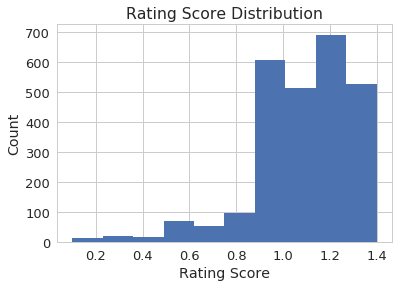

In [52]:
% pylab inline
sns.set(style="whitegrid",  font_scale=1.3);
plt.hist(ana_df.rating_score)
plt.xlabel('Rating Score');
plt.ylabel('Count');
plt.title('Rating Score Distribution');

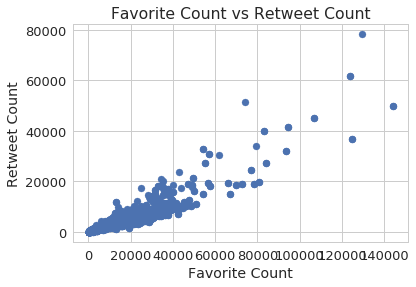

In [53]:
plt.scatter(x=ana_df.favorite_count, y=ana_df.retweet_count)
plt.xlabel('Favorite Count');
plt.ylabel('Retweet Count');
plt.title('Favorite Count vs Retweet Count');

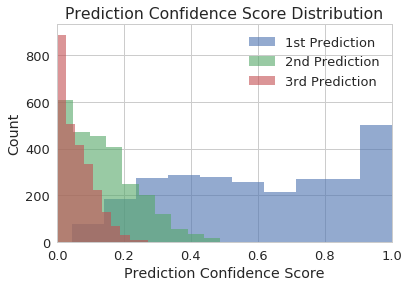

In [54]:
plt.hist(ana_df['p1_conf'],  alpha=0.6, label='1st Prediction');
plt.hist(ana_df['p2_conf'],  alpha=0.6, label='2nd Prediction');
plt.hist(ana_df['p3_conf'],  alpha=0.6, label='3rd Prediction');
plt.xlim(0,1.0)
plt.xlabel('Prediction Confidence Score');
plt.ylabel('Count');
plt.title('Prediction Confidence Score Distribution');
plt.legend(loc='upper right');

Text(0,0.5,'Rating Score')

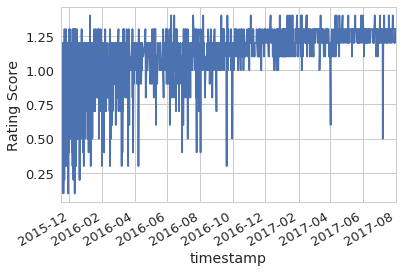

In [56]:
ana_time_df = ana_df.copy()
ana_time_df['timestamp'] = pd.to_datetime(ana_df['timestamp'])
ana_time_df.set_index('timestamp', inplace=True)
ana_time_df['rating_score'].plot()
plt.ylabel('Rating Score')

### Conclusion 

For data collection, I downloaded the twitter archive data manually, wrote http request to download the image prediction files from Udacity server programmatically, and queried the tweeter API to save all the JSON data into a txt file.

For data assessment, especially in the twitter archive data set, there were quite a lot of issues. Some data types were incorrect, for example, timestamp, dog stages, tweet id, etc. In the name column, 745 name values were missing (None). Some names especially shown in lower cases were meaningless, for example, “a”, ‘the’, ‘very’, etc. In the expanded urls’s column, 59 elements were missing. The rating numerator column had outliers of which the total counts were less than or equal to 2. Some numerator values were inconsistent with the data from the text column where fractional numerators appeared. The rating denominator were not all 10, and a few scores were not consistent with the information from the text column. Some rows contained retweet information. The “&amp;” string in the text column was quite redundant. Columns such as ‘in_reply_to_status_id’, 'in_reply_to_user_id', 'retweeted_status_id were useless. For the additional data set acquired via tweepy, only ‘id’, ‘favorite count’ and ‘retweet count’ were useful, but ‘id’ was confusing. For data tidiness issues, in the tweet archive data set, four columns: doggo, floofer, pupper and puppo were redundant. Some tweet id did not have corresponding images in the image prediction data set. Tweet id appeared 3 times in 3 different sources.

For data cleaning, I solved all the issues. For the name issues, I cleaned the data in 3 cases. When the names were shown in lower case and the text column contained key words such as ‘name’ or ‘name is’, I used the real name extracted from the text column to replace the lower-case names. Otherwise, those names were set as None. I removed the rows where the expanded url values were missing, the ‘retweeted status id’ values were not none, or the rating numerator values were outliers. For the rows where denominators were not 10, I visually checked the text column and replaced the old denominators and numerators. After removing all the outliers, the numerator value set as 5 (it was 13.5 in the text column) was replaced by 13.5. The “&amp;” in the text column were all replaced by “&”. I also filtered the additional data set by keeping “id”, “favorite count” and ‘retweet count’, where ‘id’ was also changed to ‘tweeter id’ to remove ambiguity. Useless columns such as in_reply_to_status_id', 'in_reply_to_user_id' and 'retweeted_status_id’ were removed. The data types of timestamp, tweet id, dog stage, rating numerator and denominator were all set to the correct ones.
For data quality issues, the four columns (‘doggo’, ‘floofer’, ‘pupper’, and ‘puppo’) were combined to one. Redundant column tweet_id was cleaned and three tables were joined to a master table using inner join.